<div class="alert alert-block alert-warning"  style="background-color: #dd9df2; color: black;">  
  <h1>About</h1>
</div>

CIFAR-10 dataset: [HERE](https://www.cs.toronto.edu/~kriz/cifar.html)

# 
<div class="alert alert-block alert-warning"  style="background-color: #9df2cf; color: black;">  
  <h1>Setup</h1>
</div>

# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize, Compose
import torchvision.models as models

import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from collections import Counter
import hashlib

import faiss

# Download data

In [2]:
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5),  # mean
               (0.5, 0.5, 0.5))] # std deviation
)

training_data = CIFAR10(root="../cifar",
                        train = True, # train set, 50k images
                        download = True,
                        transform=transform)
test_data = CIFAR10(root = "../cifar",
                    train = False, # test set, 10k images
                    download = True,
                    transform = transform)

print(f"Train data: {len(training_data)} images")
print(f"Test data: {len(test_data)} images")

Train data: 50000 images
Test data: 10000 images


# 
<div class="alert alert-block alert-warning"  style="background-color: #f2a39d; color: black;">  
  <h1>Data Exploration</h1>
</div>

# Look at some images

`image, label = training_data[0]`: This grabs the first image and its label from your training_data dataset.
* `image` → A tensor of shape (3, 32, 32) → RGB image.
* `label` → An integer between 0 and 9 (CIFAR-10 class).

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

def show_image(image, label=None, scale=2):
    img = image.permute(1, 2, 0) * 0.5 + 0.5
    plt.figure(figsize=(scale, scale))
    plt.imshow(img, interpolation='nearest')
    if label is not None:
        plt.title(f"Label: {label} ({class_names[label]})")
    plt.axis('off')
    plt.show()

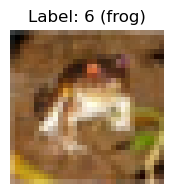

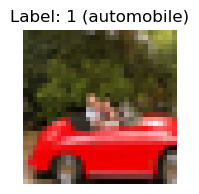

In [4]:
image, label = training_data[0]
show_image(image, label)

image, label = training_data[99]
show_image(image, label)

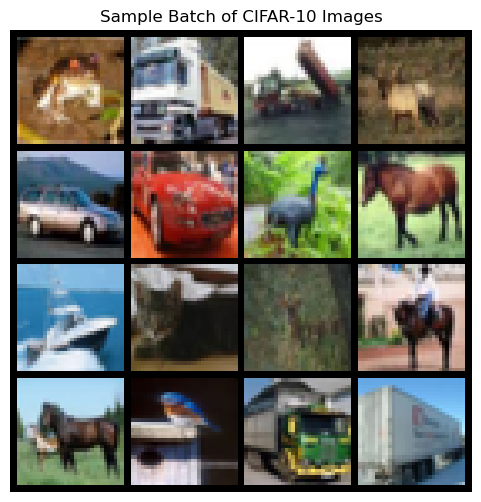

In [5]:
def show_batch(data, n=16):
    images, labels = zip(*[data[i] for i in range(n)])
    images = torch.stack(images)
    
    # Unnormalize
    images = images * 0.5 + 0.5
    
    grid_img = make_grid(images, nrow=4)
    plt.figure(figsize=(6, 6))
    plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title("Sample Batch of CIFAR-10 Images")
    plt.show()

show_batch(training_data, n=16)

# Make sure class counts are correct

In [6]:
labels = [label for _, label in training_data]
class_counts = Counter(labels)

for class_idx, count in class_counts.items():
    print(f"{class_idx} ({class_names[class_idx]}): {count} images")

6 (frog): 5000 images
9 (truck): 5000 images
4 (deer): 5000 images
1 (automobile): 5000 images
2 (bird): 5000 images
7 (horse): 5000 images
8 (ship): 5000 images
3 (cat): 5000 images
5 (dog): 5000 images
0 (airplane): 5000 images


# Check for duplicate images

The `hashlib` library is used to create hash digests (fingerprints) of data. Think of a hash like a unique "signature" for each image. If two images are identical, their hash will be the same.

In [7]:
hashes = set()
duplicates = 0

for img, _ in training_data:
    img_bytes = img.numpy().tobytes()
    hash_val = hashlib.md5(img_bytes).hexdigest()
    if hash_val in hashes:
        duplicates += 1
    else:
        hashes.add(hash_val)

print(f"Number of duplicate images: {duplicates}")

Number of duplicate images: 0


# 
<div class="alert alert-block alert-warning"  style="background-color: #9dccf2; color: black;">  
  <h1>Embedding Generation</h1>
</div>

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

embedding_model = models.resnet18(pretrained=True) # Load Pre-trained ResNet18
embedding_model.fc = nn.Identity() # Remove classification head (FC layer)

# Move model to device and set to eval mode
embedding_model = embedding_model.to(device)
embedding_model.eval()

# Define DataLoader for batch processing
batch_size = 128
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=False)

Using device: cpu


/opt/homebrew/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Generate embeddings
all_embeddings = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        embeddings = embedding_model(images)
        all_embeddings.append(embeddings.cpu())
        all_labels.append(labels)

# Concatenate all embeddings and labels
all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)

print(f"Embeddings shape: {all_embeddings.shape}")  

# Normalize embeddings (L2 Norm) — good for cosine similarity
all_embeddings = nn.functional.normalize(all_embeddings, p=2, dim=1)

# Save embeddings and labels
os.makedirs("../outputs", exist_ok=True)
np.save("../outputs/embeddings.npy", all_embeddings.numpy())
np.save("../outputs/labels.npy", all_labels.numpy())

print("Embeddings and labels saved to ../outputs/")

  0%|          | 0/391 [00:00<?, ?it/s]

100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

Embeddings shape: torch.Size([50000, 512])
Embeddings and labels saved to ../outputs/


# 
<div class="alert alert-block alert-warning"  style="background-color: #f1f29d; color: black;">  
  <h1>FAISS</h1>
</div>

In [10]:
# Load saved embeddings & labels
embeddings = np.load("../outputs/embeddings.npy")
labels = np.load("../outputs/labels.npy")

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

# Build FAISS index
embedding_dim = embeddings.shape[1]

# Create index
index = faiss.IndexFlatL2(embedding_dim)  
index.add(embeddings)
print(f"Number of vectors in index: {index.ntotal}")

# Save index 
faiss.write_index(index, "../outputs/faiss_index.index")
print("FAISS index saved to ../outputs/faiss_index.index")

Embeddings shape: (50000, 512)
Labels shape: (50000,)
Number of vectors in index: 50000
FAISS index saved to ../outputs/faiss_index.index


In [11]:
def search_and_show(query_idx, k=5):
    query_embedding = embeddings[query_idx].reshape(1, -1)
    distances, indices = index.search(query_embedding, k)

    query_img, query_label = training_data[query_idx]
    plt.figure(figsize=(10, 3))
    plt.subplot(1, k+1, 1)
    plt.imshow(query_img.permute(1, 2, 0) * 0.5 + 0.5, interpolation='nearest')
    plt.title(f"Query\n{query_label} ({class_names[query_label]})")
    plt.axis('off')

    # Retrieved Images
    for i in range(k):
        img_idx = indices[0][i]
        img, label = training_data[img_idx]
        plt.subplot(1, k+1, i+2)
        plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5, interpolation='nearest')
        plt.title(f"{label} ({class_names[label]})")
        plt.axis('off')

    plt.suptitle(f"Top-{k} Similar Images for Query Index {query_idx}")
    plt.show()

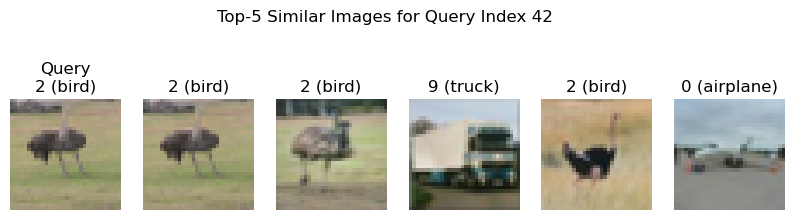

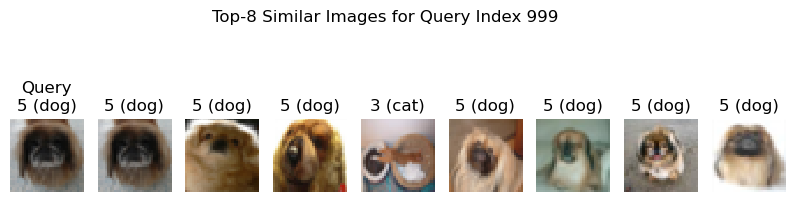

In [12]:
search_and_show(query_idx=42, k=5)
search_and_show(query_idx=999, k=8)

# 
<div class="alert alert-block alert-warning"  style="background-color: #f29db8; color: black;">  
  <h1>Evaluate</h1>
</div>

# Evaluate in supervised way

$Precision@k = \frac{\sum_{i=1}^{k} \mathbb{1}(\text{retrieved}_i = \text{query label})}{k} = \frac{\text{Number of correct retrieved images}}{k}$

In [13]:
def precision_at_k(query_idx, k=5):
    """
    Evaluate Precision@k for given index and k.

    Parameters
    ----------
        - query_idx (int): Index of data point
        - k (int or None): Number of pics to retrieve

    Returns
    -------
        - precision (float): Precision@k
    """
    query_label = labels[query_idx]
    query_embedding = embeddings[query_idx].reshape(1, -1)
    _, indices = index.search(query_embedding, k)
    retrieved_labels = labels[indices[0]]
    precision = np.sum(retrieved_labels == query_label) / k
    return precision

print(precision_at_k(42, k=5))

0.6


In [14]:
def evaluate_precision_at_k(k_values=[5, 10], sample_size=None):
    """
    Evaluate average Precision@k for given k values.

    Parameters
    ----------
        - k_values (list): List of k values (e.g., [5, 10])
        - sample_size (int or None): If provided, randomly sample this many queries instead of using all

    Returns
    -------
        - dict: {k: average_precision_at_k}
    """
    np.random.seed(42) 
    num_queries = len(labels)
    indices = np.arange(num_queries)
    if sample_size is not None:
        indices = np.random.choice(indices, size=sample_size, replace=False)

    results = {}
    for k in tqdm(k_values):
        precisions = []
        for query_idx in indices:
            query_label = labels[query_idx]
            query_embedding = embeddings[query_idx].reshape(1, -1)
            _, retrieved_indices = index.search(query_embedding, k + 1)  # +1 to exclude the query itself
            retrieved_indices = retrieved_indices[0][1:]  # skip the query image
            retrieved_labels = labels[retrieved_indices]
            correct = np.sum(retrieved_labels == query_label)
            precisions.append(correct / k)
        results[k] = np.mean(precisions)
    return results

results = evaluate_precision_at_k(k_values=[5, 10], sample_size=None)  # `None` for full dataset
for k, p in results.items():
    print(f"Precision@{k}: {p:.4f}")

100%|██████████| 2/2 [03:35<00:00, 107.53s/it]

Precision@5: 0.4596
Precision@10: 0.4373


# Evaluate in unsupervised way

Running KMeans clustering...
Clustering complete.


Running t-SNE for visualization...
t-SNE complete.


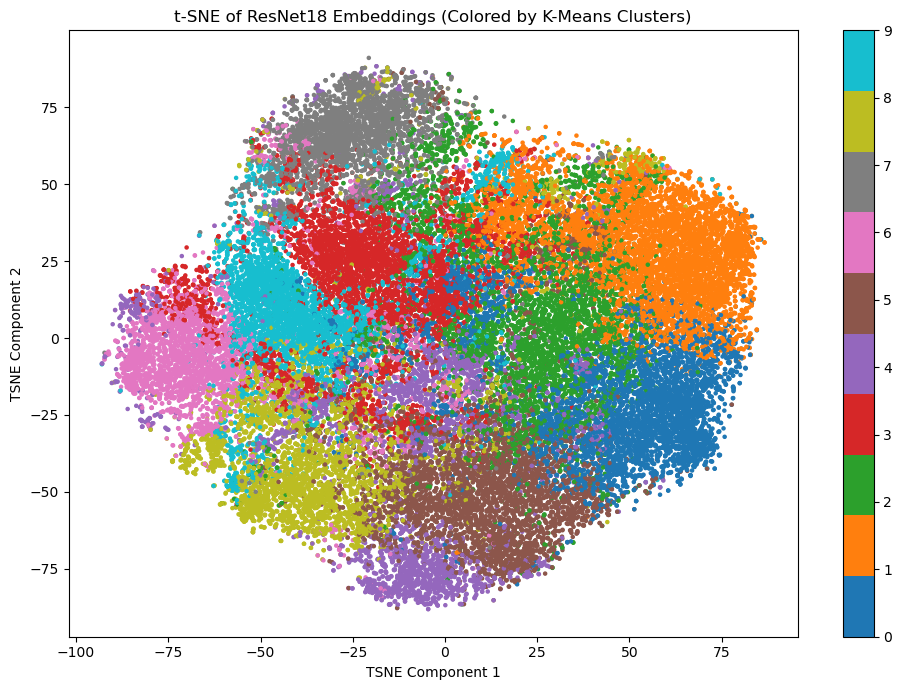

In [15]:
# Run k-means on embeddings
print("Running KMeans clustering...")
kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(embeddings)
print("Clustering complete.")

print('\n')

# Reduce dimensionality with t-SNE
print("Running t-SNE for visualization...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced = tsne.fit_transform(embeddings)
print("t-SNE complete.")

# Plot 
plt.figure(figsize=(10, 7))
plt.scatter(reduced[:, 0], reduced[:, 1], c=clusters, cmap='tab10', s=5)
plt.colorbar(ticks=range(10))
plt.title("t-SNE of ResNet18 Embeddings (Colored by K-Means Clusters)")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.tight_layout()
plt.show()